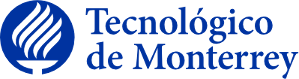

# **Maestría en Inteligencia Artificial Aplicada**

## **Proyecto Integrador - TC5035**

## Semana 3: Avance 1 - Análisis Exploratorio de Datos

### Profesores
- Dra. Grettel Barceló Alonso
- Dr. Luis Eduardo Falcón Morales

### Asesor
- Dr. Gerardo Jesús Camacho González

### Patrocinadores
- Dr. Jorge Antonio Ascencio Gutiérrez
- Yanmei King Loeza

### Equipo 29
- Carolina Lucas Dophe  –  A01702450
- Juan Pablo López Sánchez   –   A01313663
- Víctor Hugo Soto Herrera   –   A01706446

### Tabla de contenido
[Introducción](#intro)

1. [Descripción de las fuentes de datos](#fuentes)
2. [Carga de librerías y configuración inicial](#config)
3. [Carga y exploración inicial de los datos](#carga)
4. [Filtrado y limpieza de datos](#filtro)
5. [Homologación del nivel de agregación](#homologacion)
6. [Evaluación de la integración de información por variedad](#variedad)
7. [Exportación de datos](#exportacion)
8. [Análisis exploratorio de datos (EDA)](#eda)
9. [Preparación para modelado](#preparacion)
10. [Selección de enfoque de modelado](#enfoque)
11. [Análisis extendido](#extendido)

[Discusión y Conclusiones](#conclusiones)

[Referencias](#ref)

### <a class="anchor" id="intro">Introducción</a>

El presente *notebook* tiene como objetivo realizar un **análisis exploratorio de datos (EDA)** como etapa inicial del proyecto de modelado predictivo de la oferta productiva de aguacate. En esta fase se busca comprender la estructura, calidad y consistencia de los datos disponibles, así como identificar patrones generales, valores atípicos y posibles limitaciones que puedan influir en las etapas posteriores de modelado.

Dado que la **información encontrada** proviene de múltiples fuentes del SIAP, una de las primeras tareas consiste en la unificación y preparación de los datos, incluyendo la selección del cultivo y entidad de interés, la eliminación de información no relevante y la homologación de los niveles de agregación. En particular, se integrarán datos provenientes de archivos del Anuario Estadístico[[1](#ref1)] y de Datos Abiertos[[2](#ref2)], considerando variables productivas como volumen, modalidad de producción, superficie sembrada, cosechada y siniestrada, con el fin de construir un conjunto de datos consistente para el análisis.

### <a class="anchor" id="fuentes">1. Descripción de las fuentes de datos</a>

Las fuentes de datos utilizadas en este análisis corresponden a información oficial publicada por el Servicio de Información Agroalimentaria y Pesquera (SIAP), y se describen a continuación:

* **Datos Abiertos SIAP – Nivel Estado (1980–2002)**
  Conjunto de archivos anuales en formato CSV que contienen información agrícola agregada a nivel estatal, incluyendo variables productivas como superficie sembrada, superficie cosechada, volumen de producción y modalidad de producción (Riego y Temporal). Estos archivos incluyen múltiples cultivos y entidades federativas, por lo que será necesario filtrar la información correspondiente al cultivo de aguacate en el estado de Jalisco.

* **Datos Abiertos SIAP – Nivel Municipio (2003–2024)**
  Conjunto de archivos anuales en formato CSV con información desagregada a nivel municipal. Además de las variables productivas, estos archivos incluyen identificadores administrativos adicionales que no son relevantes para el alcance del proyecto. Para mantener la consistencia temporal y geográfica del análisis, esta información será agregada a nivel estatal, conservando la distinción por modalidad de producción.

* **Anuario Estadístico SIAP (1980–2024)**
  Archivo consolidado que presenta información histórica del cultivo de aguacate a nivel estatal, incluyendo variables productivas y características adicionales como la variedad del cultivo. Esta fuente se utilizará principalmente para complementar el análisis mediante información por variedad y para contextualizar la evolución productiva del cultivo a lo largo del tiempo. **`NOTA`**: la recopilación de esta información fue manual, año por año desde el sitio del Anuario Estadístico del SIAP.[[1](#ref1)]

### <a class="anchor" id="config">2. Carga de librerías y configuración inicial</a>

En esta sección se cargan las librerías necesarias para el manejo, limpieza, integración y exploración de los datos, así como algunas configuraciones básicas para facilitar la visualización y el análisis posterior.

In [2]:
# Cargar librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [3]:
# Configuración de visualización
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [4]:
# Definición de rutas base
DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

SIAP_ABIERTOS_ESTADO_DIR = RAW_DATA_DIR / "siap_abiertos_estado"
SIAP_ABIERTOS_MUNICIPIO_DIR = RAW_DATA_DIR / "siap_abiertos_municipio"
SIAP_ANUARIO_FILE = RAW_DATA_DIR / "siap_anuario" / "anuario_aguacate.csv"

### <a class="anchor" id="carga">3. Carga y exploración inicial de los datos</a>

En esta sección se realiza una primera carga de las distintas fuentes de datos con el objetivo de entender su estructura, identificar las variables disponibles y validar la granularidad temporal y geográfica antes de aplicar cualquier proceso de limpieza o agregación.

#### 3.1 Datos Abiertos SIAP – Nivel Estado (1980–2002)

Esta subsección corresponde a los archivos de Datos Abiertos del SIAP[[2](#ref2)] que contienen información agrícola agregada a nivel estatal para el periodo 1980–2002. Cada archivo representa un año e incluye múltiples cultivos y entidades federativas.

In [4]:
# Listar archivos disponibles (nivel estado)
estado_files = sorted(SIAP_ABIERTOS_ESTADO_DIR.glob("*.csv"))

len(estado_files), estado_files[:5]

(23,
 [PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1980.csv'),
  PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1981.csv'),
  PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1982.csv'),
  PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1983.csv'),
  PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1984.csv')])

In [5]:
# Cargar y concatenar todos los archivos de nivel estado
df_estado_raw = pd.concat(
    (pd.read_csv(f, encoding="latin-1") for f in estado_files),
    ignore_index=True
)

df_estado_raw.shape

(70469, 19)

In [6]:
# Mostrar las primeras filas del DataFrame
df_estado_raw.head()

,Anio,Idestado,Nomestado,Idciclo,Nomcicloproductivo,Idmodalidad,Nommodalidad,Idunidadmedida,Nomunidad,Idcultivo,Nomcultivo,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Rendimiento,Precio,Valorproduccion,Unnamed: 18
0,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,070,000.00",Ajo,"1,031.00","1,031.00",0.00,"8,926.00",8.66,7.00,"62,482.00",NaN
1,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,490,000.00",Avena forrajera en verde,715.00,711.00,4.00,"10,757.00",15.13,0.56,"5,981.00",NaN
2,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,670,000.00",Brócoli,30.00,30.00,0.00,200.00,6.67,4.00,800.00,NaN
3,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,740,000.00",Calabacita,9.00,9.00,0.00,45.00,5.00,4.00,180.00,NaN
4,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,900,000.00",Cebada forrajera en verde,17.00,17.00,0.00,223.00,13.12,0.55,123.00,NaN


In [7]:
# Mostrar información del DataFrame
df_estado_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 70469 entries, 0 to 70468
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anio                70468 non-null  float64
 1   Idestado            70468 non-null  float64
 2   Nomestado           70468 non-null  str    
 3   Idciclo             70468 non-null  float64
 4   Nomcicloproductivo  70468 non-null  str    
 5   Idmodalidad         70468 non-null  float64
 6   Nommodalidad        70468 non-null  str    
 7   Idunidadmedida      70468 non-null  float64
 8   Nomunidad           70468 non-null  str    
 9   Idcultivo           70468 non-null  float64
 10  Nomcultivo          70468 non-null  str    
 11  Sembrada            70468 non-null  float64
 12  Cosechada           70468 non-null  float64
 13  Siniestrada         70468 non-null  float64
 14  Volumenproduccion   70468 non-null  float64
 15  Rendimiento         70468 non-null  float64
 16  Precio         

#####  **`NOTA`**
- Podemos notar que existe una columna basura (`Unnamed: 18`). Después de una inspección visual, se encontraron comas al final de las líneas del archivo del año 2001. Es seguro eliminar esa columna

In [8]:
# Eliminar columnas no nombradas
df_estado_raw = df_estado_raw.loc[:, ~df_estado_raw.columns.str.contains("^Unnamed")]

# Mostrar información del DataFrame
df_estado_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 70469 entries, 0 to 70468
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anio                70468 non-null  float64
 1   Idestado            70468 non-null  float64
 2   Nomestado           70468 non-null  str    
 3   Idciclo             70468 non-null  float64
 4   Nomcicloproductivo  70468 non-null  str    
 5   Idmodalidad         70468 non-null  float64
 6   Nommodalidad        70468 non-null  str    
 7   Idunidadmedida      70468 non-null  float64
 8   Nomunidad           70468 non-null  str    
 9   Idcultivo           70468 non-null  float64
 10  Nomcultivo          70468 non-null  str    
 11  Sembrada            70468 non-null  float64
 12  Cosechada           70468 non-null  float64
 13  Siniestrada         70468 non-null  float64
 14  Volumenproduccion   70468 non-null  float64
 15  Rendimiento         70468 non-null  float64
 16  Precio         

In [9]:
# Cultivos disponibles
df_estado_raw[
    df_estado_raw["Nomcultivo"].str.startswith("A", na=False)
]["Nomcultivo"].value_counts().head(10)

Nomcultivo
Avena forrajera en verde    1411
Aguacate                     981
Arroz palay                  701
Ajo                          642
Alfalfa verde                605
Ajonjolí                     581
Avena grano                  498
Algodón hueso                328
Acelga                       283
Alpiste                      272
Name: count, dtype: int64

In [10]:
# Estados disponibles
df_estado_raw["Nomestado"].value_counts().head(10)

Nomestado
Puebla             4138
Michoacán          4015
Jalisco            4012
México             3806
Oaxaca             2967
Guanajuato         2908
Baja California    2851
Veracruz           2817
Nayarit            2775
Guerrero           2617
Name: count, dtype: int64

In [11]:
# Modalidades de producción
df_estado_raw["Nommodalidad"].value_counts()

Nommodalidad
Riego       45069
Temporal    25399
Name: count, dtype: int64

#### 3.2 Datos Abiertos SIAP – Nivel Municipio (2003–2024)

Esta subsección corresponde a los archivos de Datos Abiertos del SIAP[[2](#ref2)] con información desagregada a nivel municipal para el periodo 2003–2024. Estos archivos incluyen identificadores administrativos adicionales que permiten mayor detalle geográfico, pero que deberán ser agregados para mantener la consistencia con los datos históricos.

In [12]:
# Listar archivos disponibles (nivel municipio)
municipio_files = sorted(SIAP_ABIERTOS_MUNICIPIO_DIR.glob("*.csv"))

len(municipio_files), municipio_files[:5]

(22,
 [PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2003.csv'),
  PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2004.csv'),
  PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2005.csv'),
  PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2006.csv'),
  PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2007.csv')])

In [13]:
df_municipio_raw = pd.concat(
    (pd.read_csv(f, encoding="latin-1") for f in municipio_files),
    ignore_index=True
)

df_municipio_raw.shape

/Users/juan.lopez/tmp/ipykernel_84312/505498559.py:2: DtypeWarning: Columns (0: Rendimiento) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, encoding="latin-1") for f in municipio_files),
/Users/juan.lopez/tmp/ipykernel_84312/505498559.py:2: DtypeWarning: Columns (0: Volumenproduccion) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, encoding="latin-1") for f in municipio_files),


(793769, 26)

#####  **`NOTA`**
Durante la exploración inicial se identificaron valores no numéricos y formatos inconsistentes en algunas variables productivas, los cuales fueron estandarizados y convertidos a valores numéricos o nulos según correspondiera, previo a la agregación de la información.

In [14]:
# Filtrar valores no convertibles a número en Volumenproduccion
volumen_no_numerico = df_municipio_raw[
    pd.to_numeric(df_municipio_raw["Volumenproduccion"], errors="coerce").isna()
    & df_municipio_raw["Volumenproduccion"].notna()
]["Volumenproduccion"]

volumen_no_numerico.value_counts().head(10)

Volumenproduccion
3,350.00    1
Name: count, dtype: int64

In [15]:
# Reemplazar comas y convertir a numérico
df_municipio_raw["Volumenproduccion"] = (
    df_municipio_raw["Volumenproduccion"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

df_municipio_raw["Volumenproduccion"] = pd.to_numeric(
    df_municipio_raw["Volumenproduccion"], errors="coerce"
)

In [16]:
# Verificar el tipo de dato después de la conversión
df_municipio_raw["Volumenproduccion"].dtype

dtype('float64')

In [17]:
# Filtrar valores no convertibles a número en Rendimiento
rendimiento_no_numerico = df_municipio_raw[
    pd.to_numeric(df_municipio_raw["Rendimiento"], errors="coerce").isna()
    & df_municipio_raw["Rendimiento"].notna()
]["Rendimiento"]

rendimiento_no_numerico.value_counts().head(10)

Rendimiento
#¡NUM!    2
Name: count, dtype: int64

In [18]:
# Reemplazar valores no numéricos específicos en Rendimiento
df_municipio_raw["Rendimiento"] = (
    df_municipio_raw["Rendimiento"]
    .replace("#¡NUM!", np.nan)
)

df_municipio_raw["Rendimiento"] = pd.to_numeric(
    df_municipio_raw["Rendimiento"], errors="coerce"
)

In [19]:
# Verificar valores nulos después de la conversión
df_municipio_raw[["Volumenproduccion", "Rendimiento"]].isna().sum()

Volumenproduccion      0
Rendimiento          489
dtype: int64

In [20]:
# Verificar los tipos de datos finales
df_municipio_raw[["Volumenproduccion", "Rendimiento"]].dtypes

Volumenproduccion    float64
Rendimiento          float64
dtype: object

In [21]:
# Mostrar las primeras filas del DataFrame
df_municipio_raw.head()

,Anio,Idestado,Nomestado,Idddr,Nomddr,Idcader,Nomcader,Idmunicipio,Nommunicipio,Idciclo,Nomcicloproductivo,Idmodalidad,Nommodalidad,Idunidadmedida,Nomunidad,Idcultivo,Nomcultivo,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Rendimiento,Precio,Valorproduccion,Nomcultivo Sin Um,Preciomediorural
0,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,5490000,Avena forrajera en verde,"1,062.00","1,062.00",0.00,"28,529.00",26.86,323.40,"9,226,278.60",NaN,NaN
1,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,5900000,Cebada forrajera en verde,2.00,2.00,0.00,54.00,27.00,250.00,"13,500.00",NaN,NaN
2,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,5980000,Centeno forrajero en verde,17.00,17.00,0.00,"1,020.00",60.00,350.00,"357,000.00",NaN,NaN
3,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,9090000,Triticale forrajero en verde,24.00,24.00,0.00,720.00,30.00,400.00,"288,000.00",NaN,NaN
4,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,15050000,Pastos y praderas,415.00,415.00,0.00,"25,830.00",62.24,314.90,"8,133,867.00",NaN,NaN


In [22]:
# Mostrar información del DataFrame
df_municipio_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 793769 entries, 0 to 793768
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Anio                793769 non-null  int64  
 1   Idestado            793769 non-null  int64  
 2   Nomestado           793769 non-null  str    
 3   Idddr               793769 non-null  int64  
 4   Nomddr              793769 non-null  str    
 5   Idcader             793769 non-null  int64  
 6   Nomcader            793769 non-null  str    
 7   Idmunicipio         793769 non-null  int64  
 8   Nommunicipio        793769 non-null  str    
 9   Idciclo             793769 non-null  int64  
 10  Nomcicloproductivo  793769 non-null  str    
 11  Idmodalidad         793769 non-null  int64  
 12  Nommodalidad        793769 non-null  str    
 13  Idunidadmedida      793769 non-null  int64  
 14  Nomunidad           793769 non-null  str    
 15  Idcultivo           793769 non-null  int64  


#####  **`NOTAS`**
- Después de las correcciones aplicadas a las variables productivas `Volumenproduccion` y `Rendimiento`, notamos que `Sembrada` se muestra como **object**. 
- Podemos notar que hay variantes de nombres en dos columnas:
  - **Precio** también aparece como **Preciomediorural**
  - **Nomcultivo** también aparece como **Nomcultivo Sin Um**

Por este motivo es necesario revisar lo que pasa con la variable `Sembrada` y necesitamos unificar las dos variables con nombres alternos.

In [23]:
# Mostrar las primeras filas de Sembrada
df_municipio_raw["Sembrada"].head(5)

0   1,062.00
1       2.00
2      17.00
3      24.00
4     415.00
Name: Sembrada, dtype: object

In [24]:
# Revisar valores no numéricos en Sembrada
pd.to_numeric(df_municipio_raw["Sembrada"], errors="coerce").isna().sum()

np.int64(2)

In [25]:
# Reemplazar comas y convertir a numérico
df_municipio_raw["Sembrada"] = (
    df_municipio_raw["Sembrada"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

df_municipio_raw["Sembrada"] = pd.to_numeric(
    df_municipio_raw["Sembrada"], errors="coerce"
)

In [26]:
# Verificar el tipo de dato después de la conversión
df_municipio_raw["Sembrada"].dtype

dtype('float64')

In [27]:
# Renombrar columnas para ser consistentes
column_mapping = {
    "Nomcultivo Sin Um": "Nomcultivo",
    "Preciomediorural": "Precio"
}


# Función para normalizar columnas según el mapeo dado
def normalize_columns(df, column_mapping):
    df = df.copy()
    
    for old_col, new_col in column_mapping.items():
        if old_col in df.columns:
            if new_col in df.columns:
                df[new_col] = df[new_col].fillna(df[old_col])
            else:
                df = df.rename(columns={old_col: new_col})
            df = df.drop(columns=[old_col])
    
    return df

df_municipio_raw = normalize_columns(df_municipio_raw, column_mapping)

In [28]:
# Mostrar información del DataFrame después de las correcciones
df_municipio_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 793769 entries, 0 to 793768
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Anio                793769 non-null  int64  
 1   Idestado            793769 non-null  int64  
 2   Nomestado           793769 non-null  str    
 3   Idddr               793769 non-null  int64  
 4   Nomddr              793769 non-null  str    
 5   Idcader             793769 non-null  int64  
 6   Nomcader            793769 non-null  str    
 7   Idmunicipio         793769 non-null  int64  
 8   Nommunicipio        793769 non-null  str    
 9   Idciclo             793769 non-null  int64  
 10  Nomcicloproductivo  793769 non-null  str    
 11  Idmodalidad         793769 non-null  int64  
 12  Nommodalidad        793769 non-null  str    
 13  Idunidadmedida      793769 non-null  int64  
 14  Nomunidad           793769 non-null  str    
 15  Idcultivo           793769 non-null  int64  


In [29]:
# Número de municipios distintos
df_municipio_raw["Nommunicipio"].nunique()

2314

In [30]:
# Modalidades de producción
df_municipio_raw["Nommodalidad"].value_counts()

Nommodalidad
Riego       431053
Temporal    362716
Name: count, dtype: int64

#### 3.3 Anuario Estadístico SIAP

El Anuario Estadístico del SIAP[1](#ref1)] contiene información consolidada del cultivo de aguacate a nivel estatal para todo el periodo de análisis, incluyendo variables productivas y características adicionales como la variedad del cultivo.

In [31]:
# Cargar datos del anuario, usamos UTF-8-SIG para evitar problemas con BOM
df_anuario_raw = pd.read_csv(SIAP_ANUARIO_FILE, encoding="utf-8-sig") 

df_anuario_raw.shape

(68, 14)

In [32]:
# Mostrar las primeras filas del DataFrame
df_anuario_raw.head()

,Anio,Nomcultivo,Variedad,Nomunidad,TipoTecnologia,TipoProduccion,TipoMercado,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Rendimiento,Precio,Valorproduccion
0,1980,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"3,250.00","2,885.00",0,"28,377.00",9.84,20,567.54
1,1981,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"3,190.00","3,121.00",0,"28,444.00",9.11,22.32,634.81
2,1982,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"3,190.00","3,131.00",0,"29,018.00",9.27,25.03,726.23
3,1983,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"1,840.00","1,503.00",0,"11,765.00",7.83,31.5,370.6
4,1984,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"3,190.00","3,131.00",0,"24,155.00",7.71,79.82,"1,928.05"


In [33]:
# Mostrar información del DataFrame
df_anuario_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               68 non-null     int64  
 1   Nomcultivo         68 non-null     str    
 2   Variedad           68 non-null     str    
 3   Nomunidad          68 non-null     str    
 4   TipoTecnologia     68 non-null     str    
 5   TipoProduccion     68 non-null     str    
 6   TipoMercado        68 non-null     str    
 7   Sembrada           68 non-null     str    
 8   Cosechada          68 non-null     str    
 9   Siniestrada        68 non-null     int64  
 10  Volumenproduccion  68 non-null     str    
 11  Rendimiento        68 non-null     float64
 12  Precio             68 non-null     str    
 13  Valorproduccion    68 non-null     str    
dtypes: float64(1), int64(2), str(11)
memory usage: 7.6 KB


In [34]:
# Mostrar conteo de variedades
df_anuario_raw["Variedad"].value_counts()

Variedad
Aguacate s/clasificar    28
Aguacate criollo         20
Aguacate hass            20
Name: count, dtype: int64

### <a class="anchor" id="filtro">4. Filtrado y limpieza de datos</a>

A partir de esta etapa, el análisis se restringe exclusivamente al cultivo de aguacate en el estado de Jalisco. Este filtrado es fundamental para asegurar la coherencia del conjunto de datos con el alcance del proyecto y evitar sesgos derivados de la inclusión de información de otros cultivos o entidades federativas.

In [35]:
# Filtrar datos de aguacate en Jalisco (dataframe de datos a nivel estado)
df_estado = df_estado_raw.copy()

df_estado = df_estado[
    (df_estado["Nomcultivo"].str.upper() == "AGUACATE") &
    (df_estado["Nomestado"].str.upper() == "JALISCO")
]

df_estado.shape

(46, 18)

In [36]:
# Filtrar datos de aguacate en Jalisco (dataframe de datos a nivel municipio)
df_municipio = df_municipio_raw.copy()

df_municipio = df_municipio[
    (df_municipio["Nomcultivo"].str.upper() == "AGUACATE") &
    (df_municipio["Nomestado"].str.upper() == "JALISCO")
]

df_municipio.shape


(1731, 24)

In [37]:
# Filtrar datos de aguacate (dataframe de datos del anuario)
# NOTA: esto no es necesario porque el anuario solo tiene datos de aguacate, pero
#       se incluye el paso en caso de que el anuario contenga otros cultivos en el futuro
df_anuario = df_anuario_raw.copy()

df_anuario = df_anuario[
    df_anuario["Nomcultivo"].str.upper() == "AGUACATE"
]

df_anuario.shape

(68, 14)

In [38]:
# Eliminar columnas no relevantes en df_municipio
cols_no_relevantes = [
    "Idddr", "Nomddr",
    "Idcader", "Nomcader",
    "Idmunicipio", "Nommunicipio"
]

df_municipio = df_municipio.drop(columns=cols_no_relevantes)

df_municipio.info()

<class 'pandas.DataFrame'>
Index: 1731 entries, 9430 to 765899
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anio                1731 non-null   int64  
 1   Idestado            1731 non-null   int64  
 2   Nomestado           1731 non-null   str    
 3   Idciclo             1731 non-null   int64  
 4   Nomcicloproductivo  1731 non-null   str    
 5   Idmodalidad         1731 non-null   int64  
 6   Nommodalidad        1731 non-null   str    
 7   Idunidadmedida      1731 non-null   int64  
 8   Nomunidad           1731 non-null   str    
 9   Idcultivo           1731 non-null   int64  
 10  Nomcultivo          1731 non-null   str    
 11  Sembrada            1731 non-null   float64
 12  Cosechada           1731 non-null   float64
 13  Siniestrada         1731 non-null   float64
 14  Volumenproduccion   1731 non-null   float64
 15  Rendimiento         1731 non-null   float64
 16  Precio           

In [39]:
# Validar que solamente haya un estado y un cultivo en df_estado
df_estado["Nomestado"].unique(), df_estado["Nomcultivo"].unique()

(<StringArray>
 ['Jalisco']
 Length: 1, dtype: str,
 <StringArray>
 ['Aguacate']
 Length: 1, dtype: str)

In [40]:
# Validar que solamente haya un estado y un cultivo en df_municipio
df_municipio["Nomestado"].unique(), df_municipio["Nomcultivo"].unique()

(<StringArray>
 ['Jalisco']
 Length: 1, dtype: str,
 <StringArray>
 ['Aguacate']
 Length: 1, dtype: str)

In [41]:
# Validar que solamente haya un cultivo en df_anuario
df_anuario["Nomcultivo"].unique()

<StringArray>
['Aguacate']
Length: 1, dtype: str

### <a class="anchor" id="homologacion">5. Homologación del nivel de agregación</a>

Los datos disponibles a partir de 2003 se encuentran desagregados a nivel municipal, mientras que los datos anteriores están agregados a nivel estatal. Para garantizar la consistencia temporal del conjunto de datos, es necesario agregar los registros municipales y homologarlos al nivel Estado – Año – Modalidad de producción.

#### Definición del nivel de agregación

**Claves de agrupación:**
- Anio
- Nommodalidad (Riego / Temporal)

**Variables a agregar:**
| Variable          | Operación          | Justificación                |
| ----------------- | ------------------ | ---------------------------- |
| Sembrada          | suma               | Superficie total sembrada    |
| Cosechada         | suma               | Superficie total cosechada   |
| Siniestrada       | suma               | Superficie total siniestrada |
| Volumenproduccion | suma               | Producción total             |
| Valorproduccion   | suma               | Valor económico total        |
| Rendimiento       | promedio ponderado | Depende de la superficie     |
| Precio            | promedio ponderado | Representa precio medio      |

In [42]:
# Promedio ponderado, para columnas de rendimiento y precio 
def weighted_average(df, value_col, weight_col):
    valid = df[[value_col, weight_col]].dropna()
    if valid.empty:
        return np.nan
    return (valid[value_col] * valid[weight_col]).sum() / valid[weight_col].sum()

In [43]:
# Agregación de datos municipales
df_municipio_agg = (
    df_municipio
    .groupby(["Anio", "Nommodalidad"])
    .apply(lambda x: pd.Series({
        "Sembrada": x["Sembrada"].sum(),
        "Cosechada": x["Cosechada"].sum(),
        "Siniestrada": x["Siniestrada"].sum(),
        "Volumenproduccion": x["Volumenproduccion"].sum(),
        "Valorproduccion": x["Valorproduccion"].sum(),
        "Rendimiento": weighted_average(x, "Rendimiento", "Cosechada"),
        "Precio": weighted_average(x, "Precio", "Volumenproduccion")
    }))
    .reset_index()
)

df_municipio_agg.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
0,2003,Riego,449.20,438.50,0.00,"3,625.70","20,911,350.00",8.27,"5,767.53"
1,2003,Temporal,231.50,177.50,0.00,"1,527.50","9,828,250.00",8.61,"6,434.21"
2,2004,Riego,368.70,303.70,0.00,"2,681.60","15,449,250.00",8.83,"5,761.21"
3,2004,Temporal,231.50,175.00,0.00,"1,552.02","9,134,160.00",8.87,"5,885.34"
4,2005,Riego,587.53,372.68,0.00,"2,864.57","17,842,770.08",7.69,"6,228.78"


In [44]:
# Preparación de datos estatales (extraer columnas relevantes)
df_estado_agg = df_estado[
    [
        "Anio", "Nommodalidad",
        "Sembrada", "Cosechada", "Siniestrada",
        "Volumenproduccion", "Valorproduccion",
        "Rendimiento", "Precio"
    ]
].copy()

df_estado_agg.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
915,"1,980.00",Riego,"2,490.00","2,210.00",0.00,"22,100.00","442,000.00",10.00,20.00
941,"1,980.00",Temporal,760.00,675.00,0.00,"6,277.00","125,540.00",9.30,20.00
3408,"1,981.00",Riego,"2,545.00","2,498.00",0.00,"24,705.00","551,366.00",9.89,22.32
3434,"1,981.00",Temporal,645.00,623.00,0.00,"3,739.00","83,447.00",6.00,22.32
5951,"1,982.00",Riego,"2,545.00","2,508.00",0.00,"24,964.00","617,060.00",9.95,24.72


In [45]:
# Unión de datos estatales y municipales
df_master = pd.concat(
    [df_estado_agg, df_municipio_agg],
    ignore_index=True
).sort_values(["Anio", "Nommodalidad"])

df_master.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
0,"1,980.00",Riego,"2,490.00","2,210.00",0.00,"22,100.00","442,000.00",10.00,20.00
1,"1,980.00",Temporal,760.00,675.00,0.00,"6,277.00","125,540.00",9.30,20.00
2,"1,981.00",Riego,"2,545.00","2,498.00",0.00,"24,705.00","551,366.00",9.89,22.32
3,"1,981.00",Temporal,645.00,623.00,0.00,"3,739.00","83,447.00",6.00,22.32
4,"1,982.00",Riego,"2,545.00","2,508.00",0.00,"24,964.00","617,060.00",9.95,24.72


**`NOTA`**: la columna de **año** (Anio) está siendo marcada como flotante. Posteriormente a la unión de los conjuntos de datos históricos, la variable temporal fue estandarizada a tipo entero para facilitar el análisis de series de tiempo.

In [46]:
df_master["Anio"] = df_master["Anio"].astype(int)

df_master.head()


,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
0,1980,Riego,"2,490.00","2,210.00",0.00,"22,100.00","442,000.00",10.00,20.00
1,1980,Temporal,760.00,675.00,0.00,"6,277.00","125,540.00",9.30,20.00
2,1981,Riego,"2,545.00","2,498.00",0.00,"24,705.00","551,366.00",9.89,22.32
3,1981,Temporal,645.00,623.00,0.00,"3,739.00","83,447.00",6.00,22.32
4,1982,Riego,"2,545.00","2,508.00",0.00,"24,964.00","617,060.00",9.95,24.72


#####  **`NOTA`**

Para garantizar la consistencia temporal del análisis, los datos originalmente disponibles a nivel municipal fueron agregados al nivel estatal mediante sumas y promedios ponderados, utilizando como referencia la superficie cosechada y el volumen producido. De esta forma se obtuvo un conjunto de datos homogéneo por año y modalidad de producción.

### <a class="anchor" id="variedad">6. Evaluación de la integración de información por variedad</a>

Explorar la factibilidad de incorporar información desagregada por variedad de aguacate (Hass, Criollo, Sin clasificar) al conjunto de datos maestro, con el fin de enriquecer el análisis y evaluar su utilidad para el modelado predictivo.

In [47]:
# Conteo de registros por año y variedad en el anuario
df_anuario.groupby(["Anio", "Variedad"]).size().unstack(fill_value=0)

Variedad,Aguacate criollo,Aguacate hass,Aguacate s/clasificar
Anio,,,
1980,0,0,1
1981,0,0,1
1982,0,0,1
1983,0,0,1
1984,0,0,1
1985,0,0,1
1986,0,0,1
1987,0,0,1
1988,0,0,1


##### **Decisión**

Aunque el Anuario Estadístico del SIAP proporciona información desagregada por variedad de aguacate, dicha información no se encuentra alineada con el nivel de modalidad de producción utilizado en el conjunto de datos principal. Por esta razón, la integración directa por variedad no se realizó, y la información fue utilizada únicamente con fines exploratorios y de análisis complementario.

Adicionalmente, el análisis exploratorio de la información por variedad muestra que, durante una parte significativa del periodo histórico (aproximadamente de 1980 a 2004), la producción de aguacate se encuentra registrada mayoritariamente bajo la categoría “Aguacate s/clasificar”, sin distinción entre variedades específicas. Esta falta de desagregación reduce sustancialmente el valor informativo de la variable `Variedad` para el análisis longitudinal y refuerza la decisión de no integrarla directamente al conjunto de datos principal.

### <a class="anchor" id="exportacion">7. Exportación de datos</a>

Una vez concluida la etapa de integración y homologación de datos, el conjunto de datos resultante fue exportado para su reutilización en las etapas posteriores de análisis exploratorio, ingeniería de características y modelado.

In [48]:
# Guardar DataFrame maestro a CSV
df_master.to_csv(
    PROCESSED_DATA_DIR / "df_master_jalisco_aguacate_1980_2024.csv",
    index=False,
    encoding="utf-8"
)

### <a class="anchor" id="eda">8. Análisis exploratorio de datos (EDA)</a>

Cargamos el DataFrame maestro.

In [58]:
df = pd.read_csv(PROCESSED_DATA_DIR / "df_master_jalisco_aguacate_1980_2024.csv")
df.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
0,1980,Riego,"2,490.00","2,210.00",0.00,"22,100.00","442,000.00",10.00,20.00
1,1980,Temporal,760.00,675.00,0.00,"6,277.00","125,540.00",9.30,20.00
2,1981,Riego,"2,545.00","2,498.00",0.00,"24,705.00","551,366.00",9.89,22.32
3,1981,Temporal,645.00,623.00,0.00,"3,739.00","83,447.00",6.00,22.32
4,1982,Riego,"2,545.00","2,508.00",0.00,"24,964.00","617,060.00",9.95,24.72


*¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?*

In [ ]:
# Porcentaje de valores faltantes
num_rows = df.shape[0]
print("Valores nulos:\n")

for col in df.columns:
    na = ((df[col].notna().count() - num_rows) * 100) / num_rows
    print(f'{col}: {na}')

Valores nulos:

Anio: 0.0
Nommodalidad: 0.0
Sembrada: 0.0
Cosechada: 0.0
Siniestrada: 0.0
Volumenproduccion: 0.0
Valorproduccion: 0.0
Rendimiento: 0.0
Precio: 0.0


Para este dataset no se cuentan con datos faltantes en ninguna columna, lo cual es de mucha ayuda para ahorrarnos el proceso de imputar datos o deshacernos de columnas severamente dañadas.

*¿Cuáles son las estadísticas resumidas del conjunto de datos?*

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               90 non-null     int64  
 1   Nommodalidad       90 non-null     object 
 2   Sembrada           90 non-null     float64
 3   Cosechada          90 non-null     float64
 4   Siniestrada        90 non-null     float64
 5   Volumenproduccion  90 non-null     float64
 6   Valorproduccion    90 non-null     float64
 7   Rendimiento        90 non-null     float64
 8   Precio             90 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 6.5+ KB


En nuestro dataset se puede observar que en su mayoría está compuesto por variables numéricas, siendo 'Anio' la única columna con valores numéricos enteros, mientras que el resto son valores con decimales. La columna 'Nommodalidad' es la única del dataset que tiene datos de tipo categóricos, es decir de texto.

In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Anio,90.00,"2,002.00",13.06,"1,980.00","1,991.00","2,002.00","2,013.00","2,024.00"
Sembrada,90.00,"3,924.32","6,514.62",41.00,467.52,856.69,"3,725.91","27,627.94"
Cosechada,90.00,"3,069.60","5,566.78",38.00,359.23,634.41,"2,754.97","25,634.31"
Siniestrada,90.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Volumenproduccion,90.00,"32,930.16","66,728.13",314.00,"3,070.68","6,312.86","24,925.32","314,206.58"
Valorproduccion,90.00,"617,272,283.18","1,654,407,102.82","27,500.00","1,707,337.50","17,893,825.04","306,029,046.02","8,580,088,223.56"
Rendimiento,90.00,9.22,1.81,4.69,8.27,9.33,10.10,13.55
Precio,90.00,"8,010.82","8,077.89",20.00,"1,230.16","5,764.37","12,939.06","32,102.94"


En las estadísticas generales de las variables numéricas, se puede observar que la variable 'Siniestrada' solo tiene valores de 0, ya que tanto su mínimo como su máximo tienen el mismo valor de 0, lo que indica que en nuestro dataset no existen registros anuales que contemplen cantidad de territorio dañado. Por esto mismo es que se eliminará esta variable por no aportar ningún valor a nuestro dataset.

In [ ]:
# Eliminar columna 'Siniestrada'
df = df.drop(columns=['Siniestrada'])
df.columns

Index(['Anio', 'Nommodalidad', 'Sembrada', 'Cosechada', 'Volumenproduccion',
       'Valorproduccion', 'Rendimiento', 'Precio'],
      dtype='object')

Otro detalle que se puede resaltar es la gran diversidad de precios que existen para el aguacate. Se puede observar que el precio promedio mínimo ronda en 20 pesos y el máximo en 32,000. Igualmente, a través de los cuartiles se puede analizar que la mayoría de los registros no tienen precios superiores a los 15,000, y son la minoría los que superan ese precio.

De la misma forma, se puede observar que existe una gran diferencia entre una mitad de registros y otra en cuanto al valor de producción, y es que a través de los cuartiles se puede ver que el 50% de los registros tienen un valor menor a 18,000,000; mientras que existe un 25% de registros que son mayores a esa cifra y menores de 306,000,000.

In [63]:
df.describe(exclude=np.number).T

,count,unique,top,freq
Nommodalidad,90,2,Riego,45


En las estadísticas generales de las variables categóricas, se puede observar que la variable 'Nommodalidad' solo contiene 2 tipos de datos, y aunque la estadística indica que el registro que más se repite es 'Riego', realmente ambas se repiten con la misma frecuencia, 45 veces cada una en un conjunto de 90 registros en total.

*¿Hay valores atípicos en el conjunto de datos?*

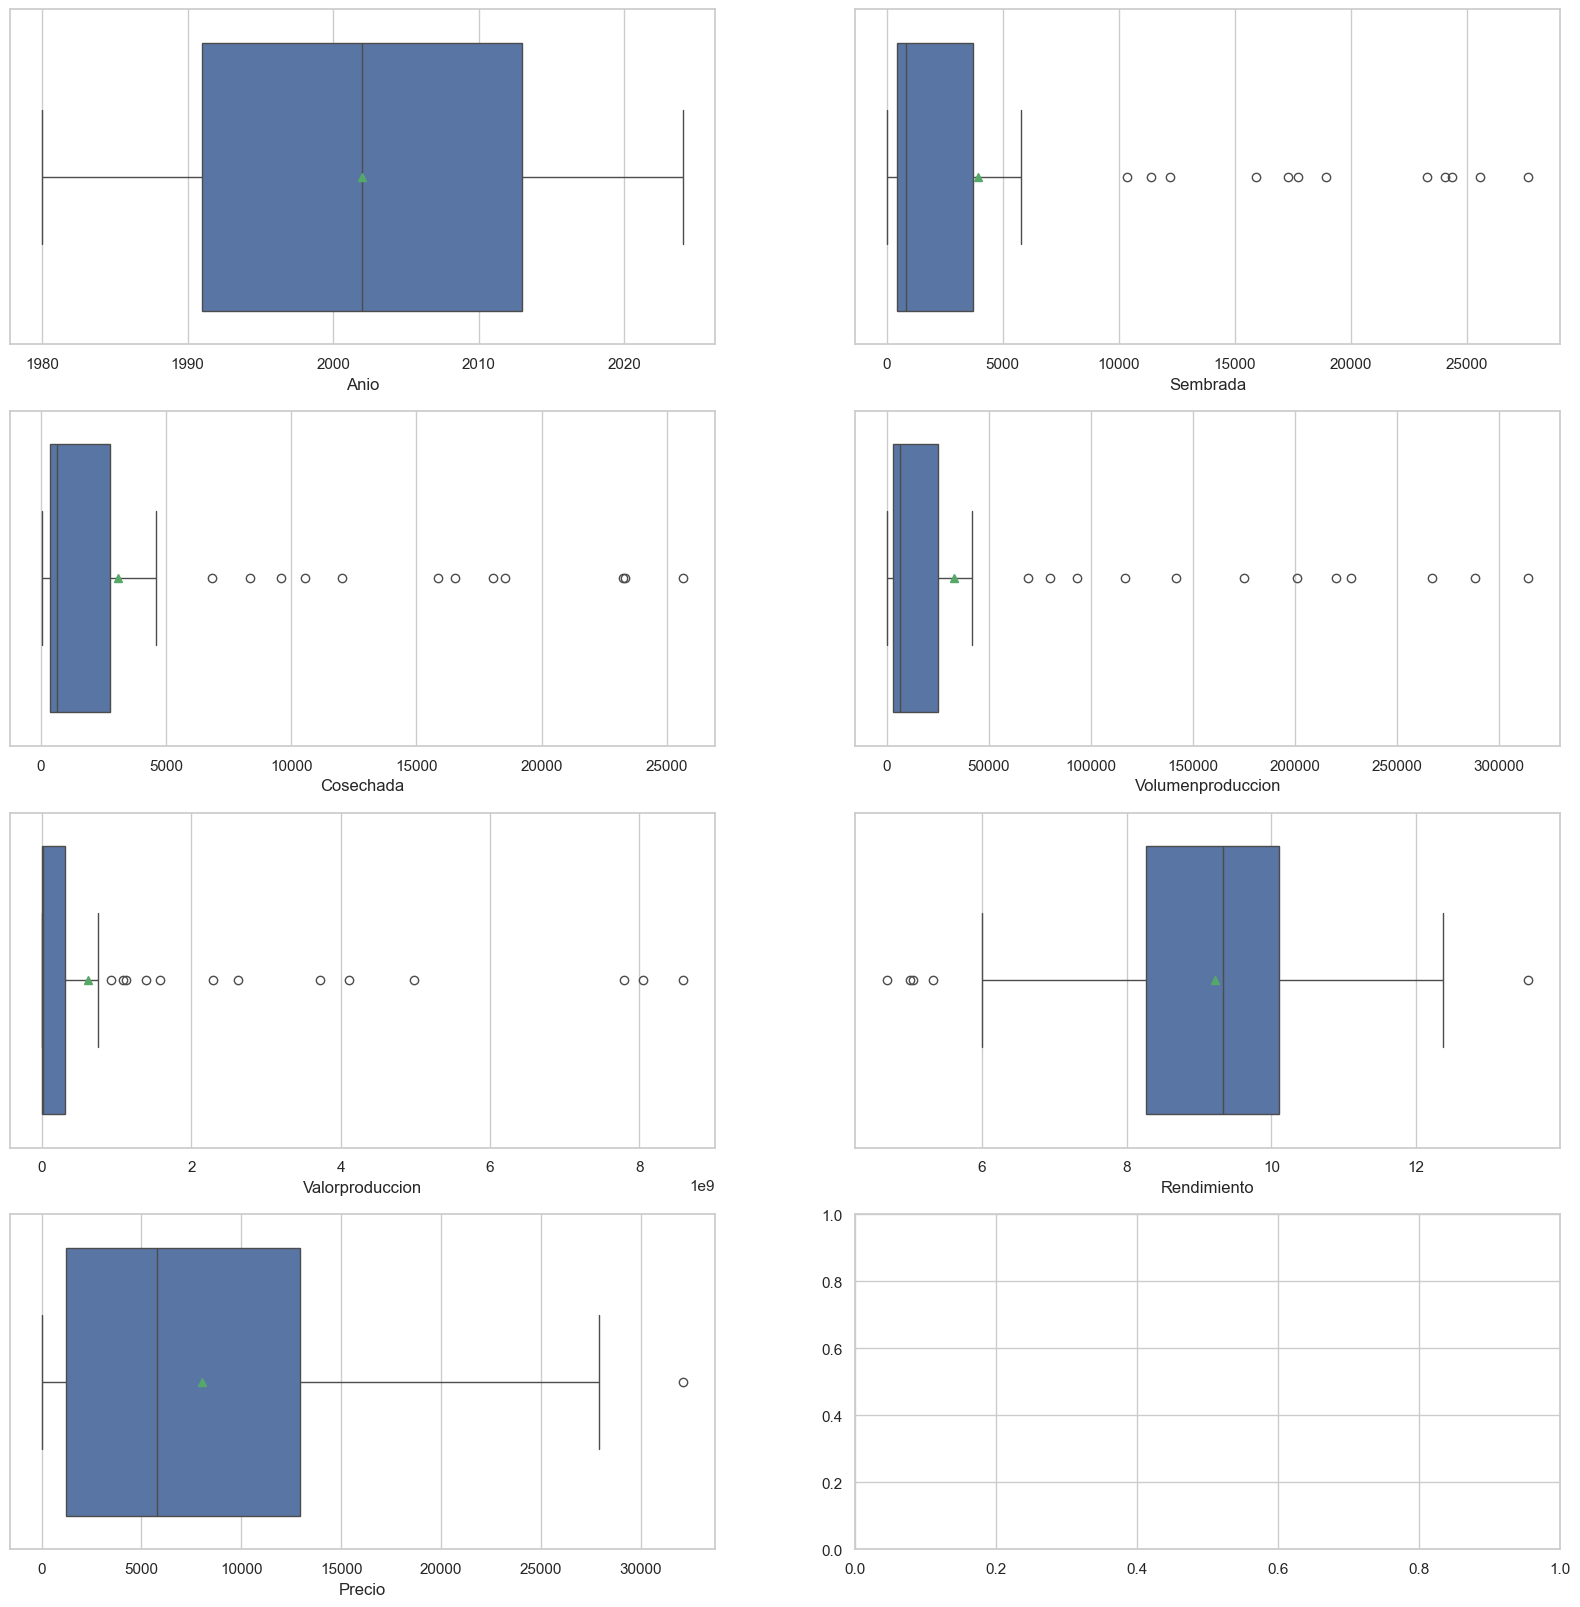

In [ ]:
# Graficar matriz de box plots para demostrar valores atípicos
figure, axes = plt.subplots(4, 2, figsize = (20,20))
axes = axes.ravel()
num_cols = ['Anio', 'Sembrada', 'Cosechada', 'Volumenproduccion', 'Valorproduccion', 'Rendimiento', 'Precio']

for col, ax in zip(num_cols, axes):
    sns.boxplot(x = df[col], ax = ax, showmeans = True)
    ax.set(xlabel = f'{col}')

A partir de los Box Plots graficados para cada columna numérica se puede observar que la columna 'Anio' es la única variable que no contiene valores atípicos; por otro lado, el resto de las variables numéricas sí contienen outliers.

Ahora con la confirmación de la existencia de valores atípicos en la mayoría de las columnas, se procederá a identificar en el dataset los registros que son atípicos y luego se eliminarán.

In [ ]:
# Identificación de valores atípicos y su eliminación del dataset
outlier_cols = ['Sembrada', 'Cosechada', 'Volumenproduccion', 'Valorproduccion', 'Rendimiento', 'Precio']

for col in outlier_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    upper_cap = q3 + 1.5 * iqr
    lower_cap = q1 - 1.5 * iqr

    outliers = df[(df[col] > upper_cap) | (df[col] < lower_cap)][col]

    df = df[~df[col].isin(outliers)]

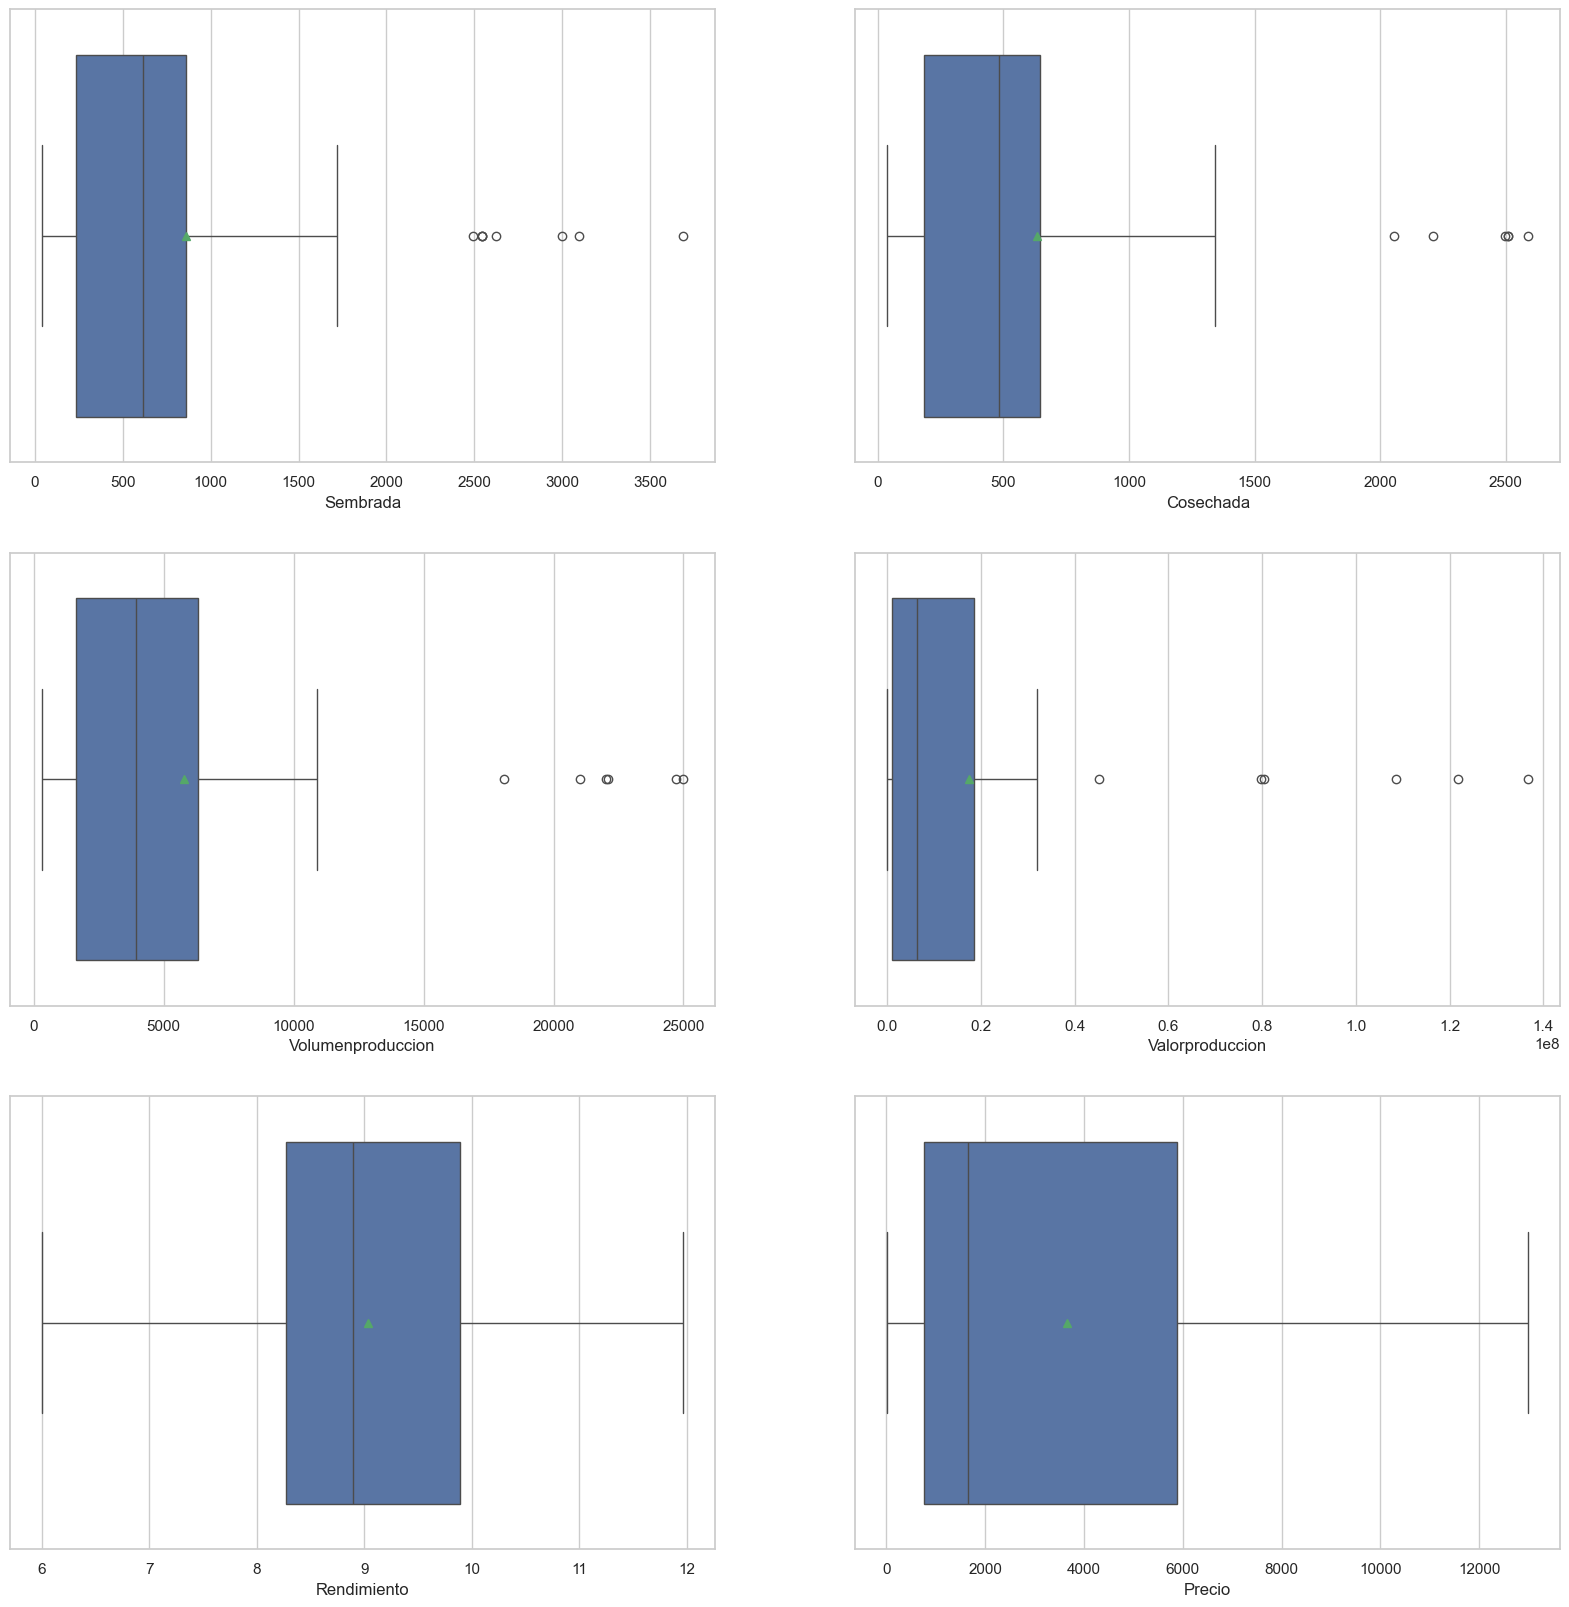

In [ ]:
# Graficar matriz de box plots con el nuevo dataset limpio
figure, axes = plt.subplots(3, 2, figsize = (20,20))
axes = axes.ravel()

for col, ax in zip(outlier_cols, axes):
    sns.boxplot(x = df[col], ax = ax, showmeans = True)
    ax.set(xlabel = f'{col}')

Al eliminar los outliers que se habían identificado previamente, podemos ver gráficas de Box Plots más limpias ahora. Particularmente, las variables 'Rendimiento' y 'Precio' ya no presentan valores atípicos. No obstante, se puede observar que el resto de las variables presentan todavía valores atípicos, pero a comparación de antes, estos nuevos valores atípicos están más cercanos al valor máximo de su respectiva columna. Por ejemplo, la columna 'Volumenproduccion' previamente tenía outliers que eran mayores a 50,000 llegando a tener hasta 300,000; ahora, tras este proceso de eliminación de outliers, aunque la variable todavía presenta valores atípicos, ahora la columna tiene al outlier más lejano en 25,000 siendo una gran mejora para esta y las demás variables que fueron procesadas.

*¿Cuál es la cardinalidad de las variables categóricas?*

<Axes: xlabel='Nommodalidad', ylabel='count'>

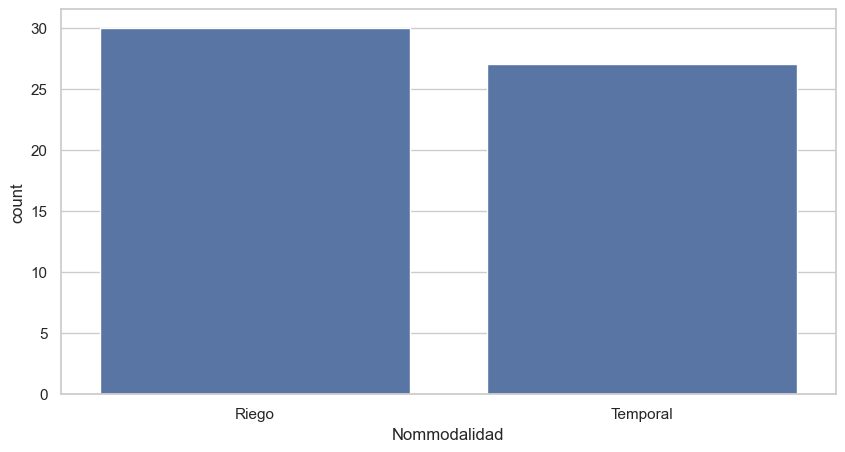

In [ ]:
# Gráfica de barras
sns.countplot(x=df['Nommodalidad'])

In [68]:
df['Nommodalidad'].value_counts()

Nommodalidad
Riego       30
Temporal    27
Name: count, dtype: int64

Numéricamente y a través de la gráfica de barras se puede observar que los tipos de datos para esta columna se encuentran equilibrados, ya que ambos tipos de datos (Riego y Temporal) tienen una diferencia de frecuencia de 3 registros.

*¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?*

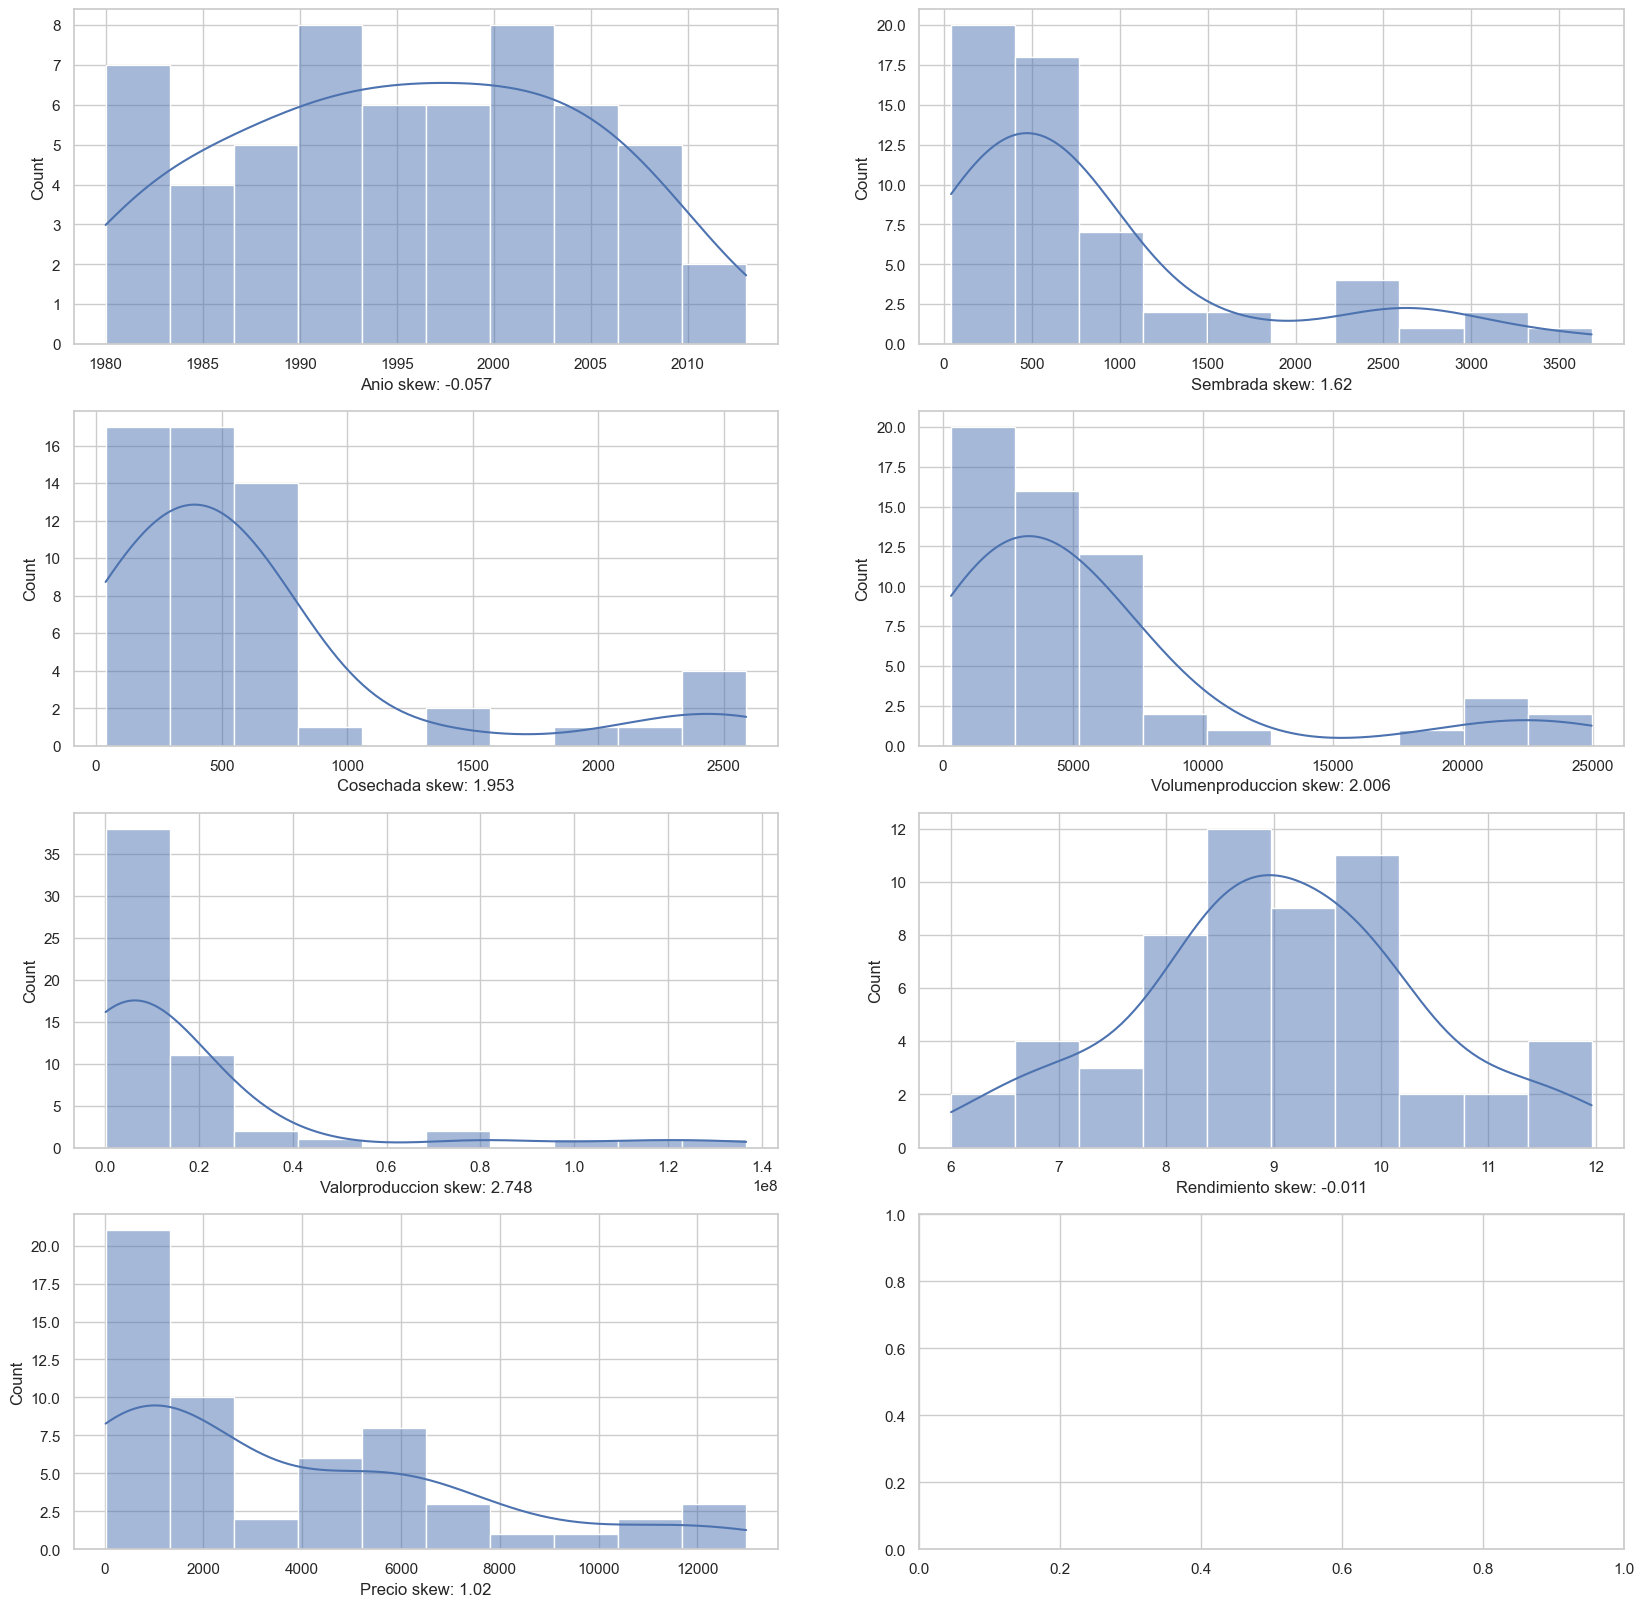

In [ ]:
# Graficar matriz de histogramas para demostrar distribuciones de los datos
figure, axis = plt.subplots(4, 2, figsize=(20,20))
axis = axis.ravel()

for col, ax in zip(num_cols, axis):
    skew = round(df[col].skew(), 3)
    sns.histplot(x = df[col], bins = 10, kde = True, ax = ax)
    ax.set(xlabel = f'{col} skew: {skew}')

En cuanto a los histogramas obtenidos por cada variable numérica, se puede destacar que las variables 'Anio' y 'Rendimiento' prácticamente no tienen asimetría, se puede observar en sus respectivos histogramas al observar que la distribución de los datos tiene una forma Gaussiana, y además porque numéricamente su asimetría es muy cercana a cero.

No obstante, el resto de las variables presentan asimetría positiva, primeramente porque todos sus datos se encuentran alineados a la izquierda en su gráfica de histograma, y porque su valor numérico es mayor a cero.

A estas variables con asimetría positiva se decidió aplicarles una transformación 'Box-Cox' ya que todos los valores presentes en cada columna son positivos, y además este método es una transformación más robusta que aplicar una transformación de raíz cuadrada, logarítmica, potencia etc.

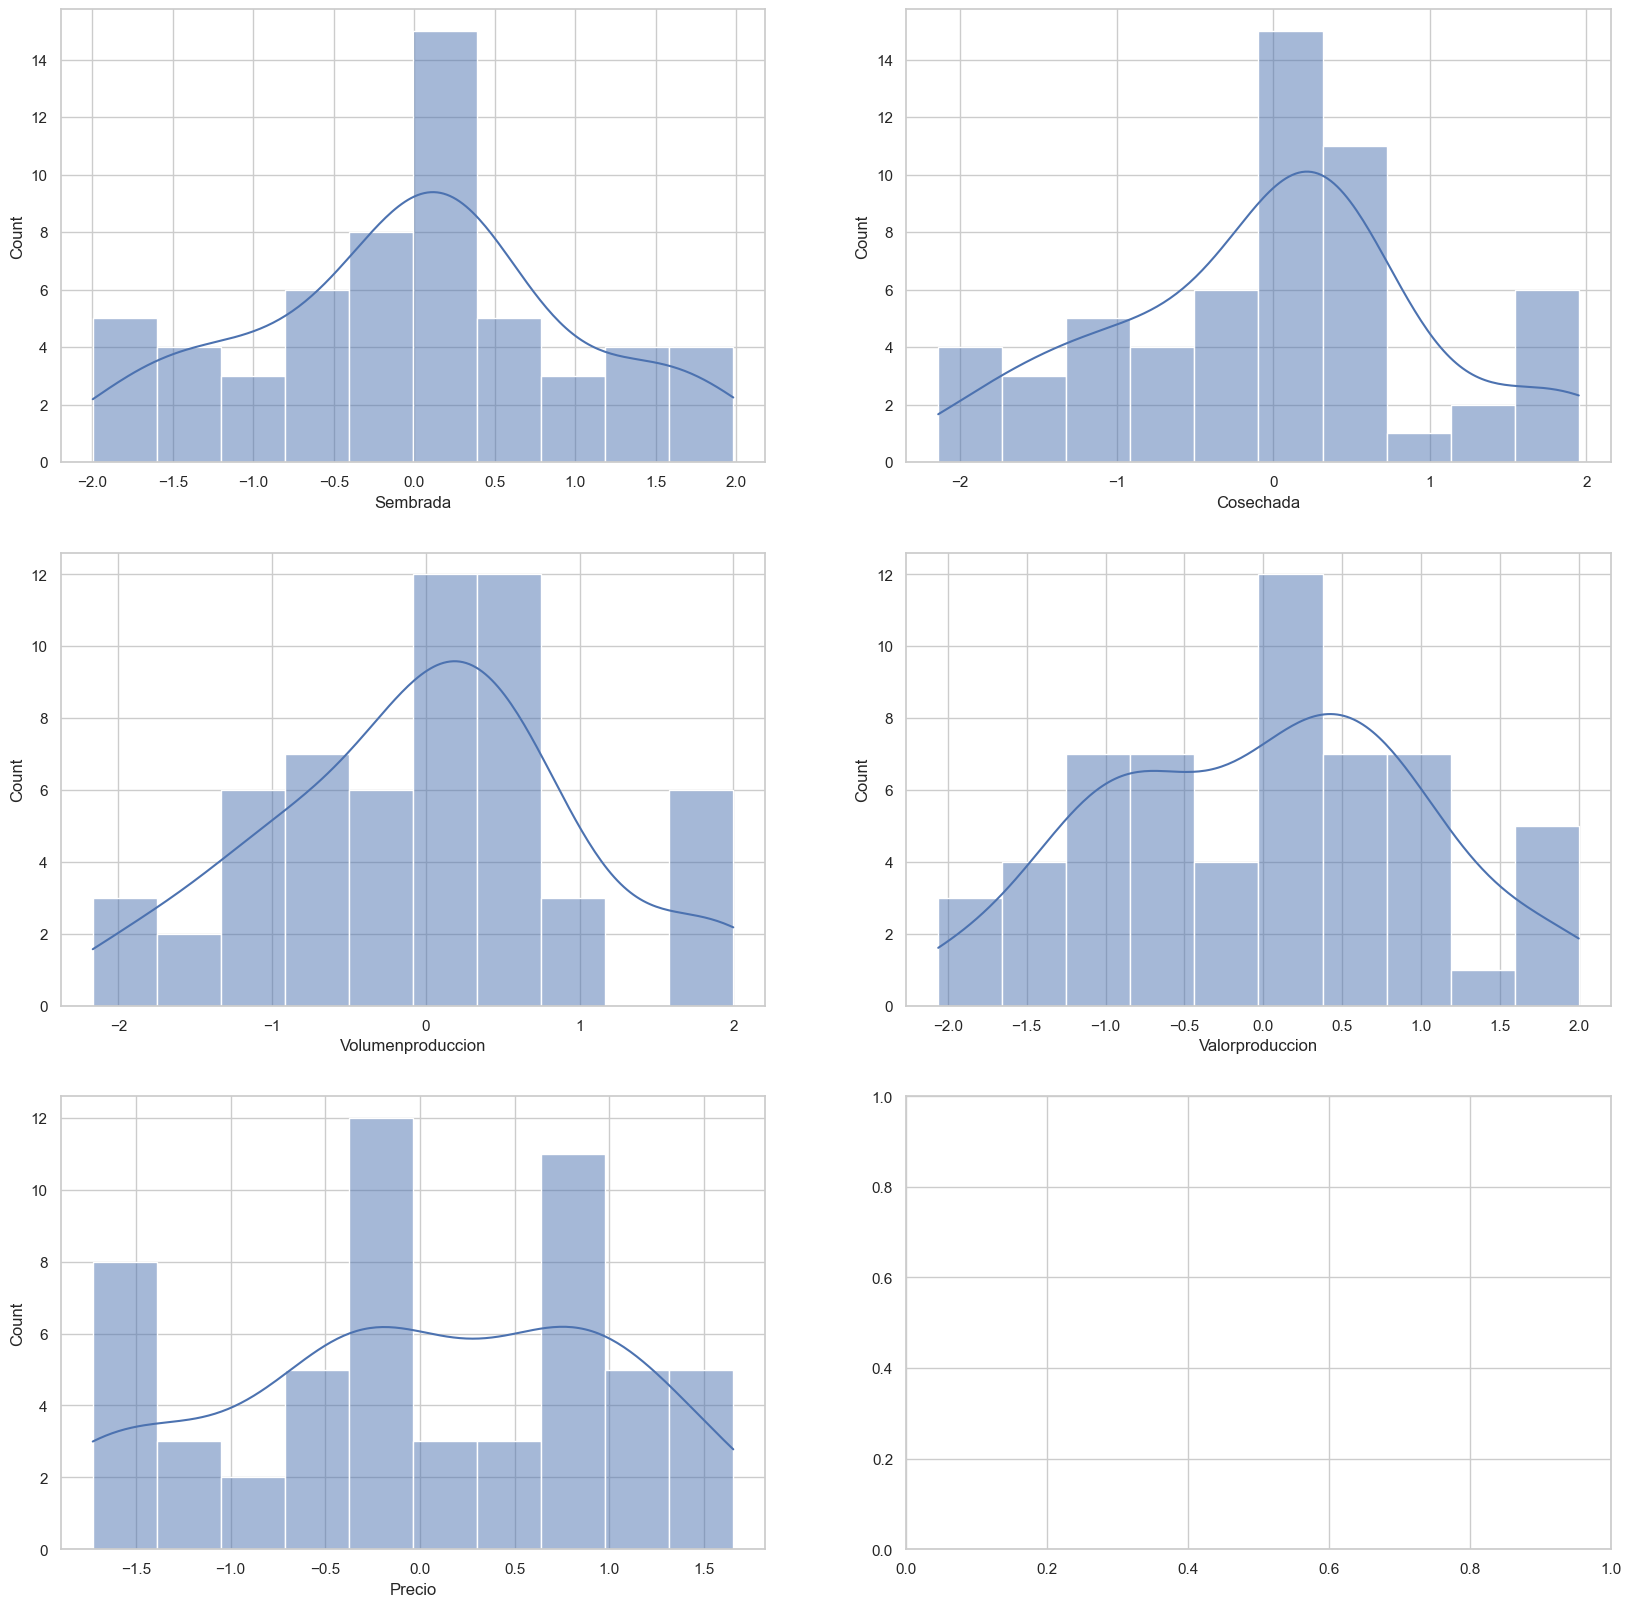

In [ ]:
# Aplicar transformación Box-Cox y graficar matriz de histogramas con la nueva distribución
from sklearn.preprocessing import power_transform

figure, axis = plt.subplots(3, 2, figsize = (20,20))
axis = axis.ravel()
skewed_cols = ['Sembrada', 'Cosechada', 'Volumenproduccion', 'Valorproduccion', 'Precio']

for col, ax in zip(skewed_cols, axis):
    df[col] = power_transform(df[[col]], method = 'box-cox')
    sns.histplot(x = df[col], bins = 10, kde = True, ax = ax)
    ax.set(xlabel = f'{col}')

Después de aplicar la transformada de 'Box-Cox' a todas las variables que tenían asimetría positiva, ahora al graficar sus histogramas, podemos observar que la distribución de absolutamente todas estas variables tiene ahora una forma Gaussiana.

Por otro lado, como se observó que la variable categórica 'Nommodalidad' tiene la misma frecuencia para sus 2 tipos de respuestas, entonces no se encuentra sesgada y no ocupa ninguna imputación o sustracción de datos.

## <a class="anchor" id="conclusiones">Conclusiones</a>

A manera de conclusión, este análisis exploratorio de datos sirvió para responder preguntas clave que nos permitieron conocer y preprocesar nuestro conjunto de datos. Primeramente, este análisis demostró que no hay valores faltantes en nuestro dataset, ahorrándonos tiempo en imputar datos o eliminar registros inválidos. Por medio del análisis de las estadísticas resumidas del conjunto de datos se pudo detectar un problema en una columna, contenía únicamente ceros, por lo que se procedió a eliminarla por no aportar información valiosa al dataset. Igualmente, se identificó que la mayoría de las columnas numéricas contenían valores atípicos, por lo que se procedió a removerlos, y aunque al final la mayoría seguía teniendo outliers, estos ya no estaban tan alejados de los límites superiores. En cuanto a la cardinalidad de las variables, únicamente se cuenta con una variable categórica, y esta variable demostró tener una cardinalidad baja, solo tiene 2 tipos de respuesta, volviéndola una variable sencilla de trabajar para posteriormente construir un modelo. De la misma forma, también se identificó que la mayoría de las variables presentan asimetría positiva en la distribución de sus datos, por lo que a estas variables se les aplicó la transformación Box-Cox y se pudo comprobar que ahora su distribución es Gaussiana.

## <a class="anchor" id="ref">Referencias</a>

[<a class="anchor" id="ref1">1</a>] Secretaría de Agricultura y Desarrollo Rural, “Cierre agrícola,” AGRICULTURA, s.f. [En línea].
Disponible en: https://nube.agricultura.gob.mx/cierre_agricola/. Accedido: 26-ene.-2026.

[<a class="anchor" id="ref2">2</a>] Secretaría de Agricultura y Desarrollo Rural, “Datos abiertos del sector agrícola,” AGRICULTURA, s.f.
[En línea]. Disponible en: https://nube.agricultura.gob.mx/datosAbiertos/Agricola.php. Accedido: 26-
ene.-2026.